In [1]:
# !pip install datasets

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Plotly imports
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
from nltk.corpus import stopwords
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from torch.optim import AdamW
from datasets import Dataset,DatasetDict, concatenate_datasets
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from kaggle_secrets import UserSecretsClient
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
competition = False
saving_model = False
print("Setup complete")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-08-26 05:17:45.686777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756185465.853073      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756185465.902715      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete


## EDA

In [3]:
if not competition:
    df_train = pd.read_csv("/kaggle/input/jigsaw-gui/train.csv")
df_test = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")

In [4]:
if not competition:
    df_train

In [5]:
df_test

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...
2,2031,Kickin' ass and selling underwear!\nJust made ...,"No Advertising: Spam, referral links, unsolici...",gonewild,Good story my friend. Check out my blog at ht...,If you know what exactly you need then you don...,CENTIPEDES\n\nSOME BASED PATRIOTS HAVE CREATED...,[So great! Thanks for sharing.](http://www.che...
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...
4,2033,bitches for free at this point show all h...,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,code free tyrande --->>> [Imgur](http://i.imgu...,My trade link\nhttps://steamcommunity.com/trad...,**HD** [ mio Stadium 102 HD](http://www.genti....,Infographics is an incredible method for showi...
5,2034,Top 10 Pentakills in August https://youtu.be/Z...,"No Advertising: Spam, referral links, unsolici...",leagueoflegends,code free tyrande --->>> [Imgur](http://i.imgu...,see tits sweet at this point http://sh.or...,its my asreddit https://www.youtube.com/watch?...,click here for more videos[Russian mafia messe...
6,2035,WIN A SAMSUNG SMARTWATCH!\n\nhttp://www.innomd...,"No Advertising: Spam, referral links, unsolici...",AskReddit,"[ENJOY 50,000 BONUS POINTS after $4,000 spent ...",We have high quality Canadian Polymer banknote...,i was on the same ios and try this jailbreak m...,We're streaming Pokemon Veitnamese Crystal RIG...
7,2036,[This mixtape is lit FAM!](https://beholdthear...,"No Advertising: Spam, referral links, unsolici...",BlackPeopleTwitter,watch good one hooters there http://https://x5...,bad pussies waiting for you herein http://gour...,[Full HD Movie Online Free](http://www.flickma...,* Computers :http://livematchstreamz.blogspot....
8,2037,must be watch movie https://sites.google.com/s...,"No Advertising: Spam, referral links, unsolici...",movies,see there hooters sweet http://url.t.aylo...,"Sign up with my link and get $1,000 of free pr...",The fact that there are pro and cons to everyt...,Oh that's interesting. You should check out my...
9,2038,Free paypal cards here!! https://www.pointspri...,"No Advertising: Spam, referral links, unsolici...",pics,she will come your home open her legs with an...,Old and young your girl-next-door make sex wi...,"i think the conjuring 2 is not bad movie ,The...","wow, she's so beautyful\n>[Sakura Vietnam](htt..."


In [6]:
if not competition:
    df_train.describe(include="object")

In [7]:
if not competition:
    df_train.rule_violation.value_counts()

In [8]:
if not competition:
    same_body = df_train.groupby("body").size().reset_index(name="cnt")
    same_body = same_body[same_body["cnt"] >1]
    display(df_train[df_train["body"] == same_body.loc[1404,"body"]].describe(include="object"))


,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
count,13,13,13,13,13,13,13
unique,1,1,12,11,12,13,13
top,We're streaming Pokemon Veitnamese Crystal RIG...,"No Advertising: Spam, referral links, unsolici...",leagueoflegends,beautiful boobs find now http://annon.lin...,porn video http://y2u.be/..https://bam.bz/OY *...,Get fit with It works [it works website ](www....,We're streaming Pokemon Veitnamese Crystal RIG...
freq,13,13,2,2,2,1,1


Plot distribution of subbredit and their respective rule violation

In [9]:
if not competition:
    data = [go.Bar(
                x = df_train.subreddit.value_counts().keys(),
                y = df_train.subreddit.value_counts().values,
                marker= dict(colorscale='Jet',
                             color = df_train.subreddit.value_counts().values
                            ),
        )]
    
    layout = go.Layout(
        title='Subreddit variable distribution'
    )
    
    fig = go.Figure(data=data, layout=layout)
    
    fig.show(renderer='iframe')
    

In [10]:
if not competition:
    counts = df_train.groupby(["subreddit", "rule_violation"]).size().reset_index(name="count")


    # Total par subreddit (pour trier)
    totals = counts.groupby("subreddit")["count"].sum().sort_values(ascending=False)

    # Réordonner counts selon ce tri
    counts["subreddit"] = pd.Categorical(counts["subreddit"], categories=totals.index, ordered=True)
    counts = counts.sort_values(["subreddit", "rule_violation"])
    
    # Séparer les deux classes (0 et 1)
    counts_0 = counts[counts.rule_violation == 0]
    counts_1 = counts[counts.rule_violation == 1]

    # Tracer les barres empilées
    fig = go.Figure(data=[
        go.Bar(
            x=counts_0["subreddit"],
            y=counts_0["count"],
            name="No Violation (0)",
            marker_color="steelblue"
        ),
        go.Bar(
            x=counts_1["subreddit"],
            y=counts_1["count"],
            name="Violation (1)",
            marker_color="firebrick"
        )
    ])

    # Layout
    fig.update_layout(
        barmode="stack",
        title="Subreddit distribution with Rule Violation split",
        xaxis_title="Subreddit",
        yaxis_title="Number of comments",
        legend=dict(title="Rule Violation")
    )

    fig.show(renderer="iframe")
    

Among the top forums, *LegalAdvice* shows a particularly high proportion of comments violating the rules, whereas *soccerstreams*, for example, has very few (only 4). 

 Such imbalance across subreddits could bias the model into “cheating” by assuming some forums, like *soccerstreams*, are always clean.

In [11]:
df_examples = pd.DataFrame({"examples":df_train[df_train.subreddit=="soccerstreams"].positive_example_1 
                            + df_train[df_train.subreddit=="soccerstreams"].positive_example_2 })
print(len(df_examples.examples.unique()))

139


However we have a good amount of negative example for soccerstreams that can helps unbalance this class

In [12]:
if not competition:
    all_words = df_train['body'].str.split(expand=True).unstack().value_counts()
    data = [go.Bar(
                x = all_words.index.values[2:50],
                y = all_words.values[2:50],
                marker= dict(colorscale='Jet',
                             color = all_words.values[2:100]
                            ),
                text='Word counts'
        )]
    
    layout = go.Layout(
        title='Top 50 (Uncleaned) Word frequencies in the training dataset'
    )
    
    fig = go.Figure(data=data, layout=layout)
    
    fig.show(renderer="iframe")

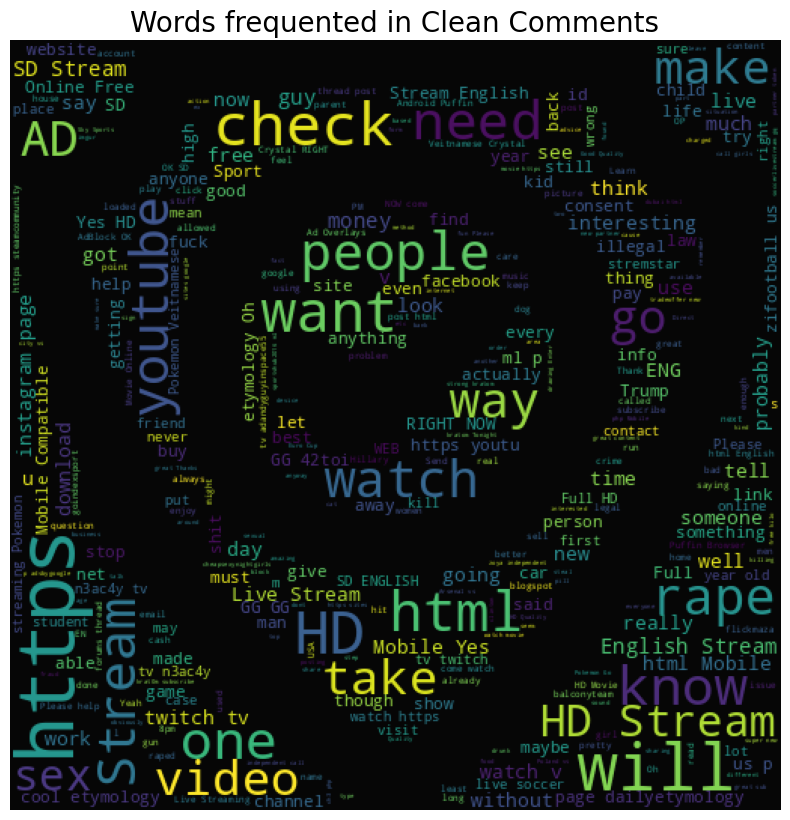

In [13]:
#clean comments
clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=df_train[df_train.rule_violation==0]
text=subset.body.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [14]:
def build_input_single_comment(row):
        text = f"""
    You are an expert moderator bot for Reddit. 
    Your task is to accurately determine whether a given Reddit comment violates a specific subreddit rule. 
    You will be provided with the subreddit name and the rule. 
    Analyze the comment carefully in the context of the provided rule and subreddit name. 
    Your final response MUST be either 'Yes' or 'No'. A 'Yes' indicates a clear violation, and a 'No' indicates no violation.    
    
    Subreddit: r/{row.subreddit}
    Rule: {row.rule}

    **Analyze the following comment:**
        
        Comment: {row.body}
        Violation:
    """
        return text
    
#id2label = {0:"No violation",1:"Rule Violation"}
def build_input(row):
    text = f"""
    r/{row.subreddit}
    Rule: {row.rule}
    
    1) {row.positive_example_1}
    Violation: Yes
    
    2) {row.positive_example_2}
    Violation: Yes
    
    3) {row.negative_example_1}
    Violation: No
    
    4) {row.negative_example_2}
    Violation: No
    
    You have to predict if the comment below violate the rule of Reddit :
    5) {row.body}
    """
    
    return text
if not competition:   
    df_train["input"] = df_train.apply(build_input, axis=1)
df_test["input"] = df_test.apply(build_input_single_comment, axis=1)
df_test["input"].iloc[0]

"\n    You are an expert moderator bot for Reddit. \n    Your task is to accurately determine whether a given Reddit comment violates a specific subreddit rule. \n    You will be provided with the subreddit name and the rule. \n    Analyze the comment carefully in the context of the provided rule and subreddit name. \n    Your final response MUST be either 'Yes' or 'No'. A 'Yes' indicates a clear violation, and a 'No' indicates no violation.    \n    \n    Subreddit: r/hiphopheads\n    Rule: No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.\n\n    **Analyze the following comment:**\n        \n        Comment: NEW RAP GROUP 17. CHECK US OUT https://soundcloud.com/user-125895482\n        Violation:\n    "

## Tokenization

In [15]:
eval_ds = Dataset.from_pandas(df_test)
if not competition:
    ds = Dataset.from_pandas(df_train)
    ds

In [16]:
model_nm = "microsoft/deberta-v3-small"
save_path = '/kaggle/input/full_continuous_prompt/tensorflow2/default/1/microsoft/deberta-v3-small_fine_tuned'
save_base = "/kaggle/input/deberta-v3-base/transformers/default/1/deberta-v3-base"
def tok_func(x): return tokz(x["input"])
if competition:
    tokz = AutoTokenizer.from_pretrained(save_path)
else:
    tokz = AutoTokenizer.from_pretrained(save_base)
    tok_ds = ds.map(tok_func, batched=True)
    tok_ds = tok_ds.rename_columns({"rule_violation":"labels"})

# To run this quickly in parallel on every row in our dataset :
toks_eval_ds = eval_ds.map(tok_func, batched=True)

Map:   0%|          | 0/2029 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [17]:
toks_eval_ds

Dataset({
    features: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10
})

## Test and validation sets

In [18]:
if not competition:
    dds = tok_ds.train_test_split(0.25, seed=42) # Put in your validation set message (body) never seen
    dds

## Metrics for evaluation

In [19]:
def auc(eval_pred):
    preds, labels = eval_pred
    # Apply softmax across the 2 logits → take probability of class 1
    exp_preds = np.exp(preds - np.max(preds, axis=1, keepdims=True))  # stability trick
    probs = exp_preds[:, 1] / exp_preds.sum(axis=1, keepdims=True)[:, 0]

    # Compute AUC only if both classes are present
    if len(np.unique(labels)) > 1:
        auc = roc_auc_score(labels, probs)
    else:
        auc = 0.0

    return {"AUC": auc}

In [20]:
bs = 16
epochs = 3
lr = 8e-5
def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column('rule_violation', 'labels')
    tok_ds = ds.map(tok_func, batched=True )
    return tok_ds

def get_model():
    if competition:
        model = AutoModelForSequenceClassification.from_pretrained(save_path)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(save_base)
    return model

def get_trainer(dds=None, model=None,is_full_dataset=False):
    if model is None: model = get_model()
    if competition:
        args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True, 
        per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=0.01, report_to='none')
        return Trainer(model, args,
                  tokenizer=tokz)
    else:
        args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        eval_strategy="epoch" if not is_full_dataset else "no", save_strategy="epoch",load_best_model_at_end=not is_full_dataset, per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2, 
        num_train_epochs=epochs, weight_decay=0.01, report_to='none')
        return Trainer(model, args, train_dataset=dds['train'] if not is_full_dataset else dds, eval_dataset=dds['test'] if not is_full_dataset else None,compute_metrics=auc,
                  tokenizer=tokz)

def get_continuous_probs(preds): # For AUC 
    probs = tf.nn.softmax(preds, axis=-1)[:, 1].numpy() 
    return probs

def get_class_probs(preds):
    return softmax
    

## Training our model

In [21]:
model = get_model()
trainer = get_trainer(dds if not competition else None, model, is_full_dataset=saving_model)

/tmp/ipykernel_18/1378150465.py:28: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [22]:
# if not competition or saving_model:
#     trainer.train()

In [23]:
if saving_model:
    save_path_fine_tuned = 'microsoft/deberta-v3-small_fine_tuned'
    trainer.save_model(save_path_fine_tuned)
    tokz.save_pretrained(save_path_fine_tuned)
    raise SystemExit

In [24]:
if competition:
    preds = trainer.predict(toks_eval_ds).predictions.astype(float)
    probs = get_continuous_probs(preds)
    submission = pd.DataFrame({
        'row_id': eval_ds['row_id'],
        'rule_violation': probs
    })
    submission.to_csv('submission.csv', index=False)
    raise SystemExit

We now want to start iterating to improve this. To do that, we need to know whether the model gives stable results. I tried training it multiples times from scratch, and got a range of outcomes for the validation loss around 0.53-0.61 and auc around (0.844-0.860). This is stable enough to make a start - if we're not finding improvements that are visible within this range, then they're not very significant! Later on, if and when we feel confident that we've got the basics right, we can use cross validation and more epochs of training.

### What worked

- Adding "You have to predict if the comment below violate the rule of Reddit :" 0.506 - 0.862

## Cross Validation

Here, all comments with the same body value go together in either train or validation. That prevents the same text from appearing in both training and validation.

In [25]:
n_folds = 4
cv = StratifiedGroupKFold(n_splits=n_folds)
idxs = np.arange(len(df_train))
df_train_mixed = df_train.sample(frac=1, random_state=42)
targets = df_train_mixed.rule_violation
folds = list(cv.split(idxs, targets, df_train_mixed.body))

def get_fold(folds, i):
    trn_idx, val_idx = folds[i]
    return DatasetDict({"train":tok_ds.select(trn_idx), "test":tok_ds.select(val_idx)})

In [26]:
train_ds = tok_ds


def build_input_separate_example(ds):

    
    # subreddit, rule, positive_example_i, negative_example_i, rule_violation
    cat = ["positive_example_", "negative_example_"]
    df = ds.to_pandas()
    final_df = df
    for c in cat:
        for i in range(1,3):
            res = df[["subreddit","rule",f"{c}{i}"]]
            res["labels"] = c == "positive_example_"
            res.rename(columns={f"{cat}{i}":"body"})
            final_df = pd.concat([final_df,res], axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(subset=["subreddit","rule","body","labels"])
    final_df["input"] = final_df.apply(build_input_single_comment, axis=1)
    final_df = final_df.dropna(subset=["labels"],axis=0)
    final_df["labels"] = final_df["labels"].astype("float32")
    ds = Dataset.from_pandas(final_df)
    ds = ds.map(tok_func, batched=True)
    return ds

train_ds = build_input_separate_example(train_ds)
test_ds = build_input_separate_example(eval_ds)
test_ds = test_ds.filter(lambda x:x["labels"] is not None)
combined_ds = concatenate_datasets([train_ds,test_ds])
print(len(train_ds))
print(len(test_ds))
print(len(combined_ds))

/tmp/ipykernel_18/1233759398.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_18/1233759398.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_18/1233759398.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_18/1233

Map:   0%|          | 0/2297 [00:00<?, ? examples/s]

/tmp/ipykernel_18/1233759398.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_18/1233759398.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_18/1233759398.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_18/1233

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20 [00:00<?, ? examples/s]

2297
20
2317


In [27]:
trainer = get_trainer(combined_ds, is_full_dataset=True)

/tmp/ipykernel_18/1378150465.py:28: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [28]:
print(f"===== Full DataSet =====")
trainer.train()

===== Full DataSet =====


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Step,Training Loss


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



TrainOutput(global_step=219, training_loss=0.2459584763060966, metrics={'train_runtime': 259.7425, 'train_samples_per_second': 26.761, 'train_steps_per_second': 0.843, 'total_flos': 902984672821008.0, 'train_loss': 0.2459584763060966, 'epoch': 3.0})

In [29]:
preds = trainer.predict(toks_eval_ds).predictions.astype(float)
print(preds)
#probs = get_continuous_probs(preds)
probs = 1 / (1 + np.exp(-preds.reshape(-1)))
print(probs)
submission = pd.DataFrame({
    'row_id': eval_ds['row_id'],
    'rule_violation': probs
})
submission.to_csv('submission.csv', index=False)
raise SystemExit

[[0.17679814]
 [0.40926251]
 [0.42738169]
 [0.19814889]
 [0.68371397]
 [0.16467354]
 [0.68583483]
 [0.16319053]
 [0.16386211]
 [0.68210399]]
[0.54408476 0.60091103 0.60524827 0.54937578 0.66456711 0.5410756
 0.66503972 0.54070733 0.54087411 0.66420812]


SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
oof_preds = np.zeros(len(df_train_mixed))   # to store fold predictions
preds_arr = []
oof_labels = df_train_mixed.rule_violation.values
fold_losses, fold_aucs = [], []
tok_ds_mixed = get_dds(df_train_mixed)
for i in range(n_folds):
    print(f"===== Fold {i+1} =====")
    
    # Build trainer
    fold = get_fold(folds, i)
    ds = build_input_separate_example(fold)
    trainer = get_trainer(ds)
    
    # Train
    trainer.train()
    
    # Evaluate (gives loss and metrics)
    eval_output = trainer.evaluate()
    fold_losses.append(eval_output["eval_loss"])
    if "eval_AUC" in eval_output:   # if your compute_metrics returns {"auc": ...}
        fold_aucs.append(eval_output["eval_AUC"])
    else:
        print("no eval_auc")
        fold_aucs.append(eval_output)
    
    # Predict on validation
    trn_idx, val_idx = folds[i]
    preds = trainer.predict(tok_ds_mixed.select(val_idx)).predictions
    probs = get_continuous_probs(preds)
    
    # Store in OOF
    oof_preds[val_idx] = probs

In [ ]:
# Average validation loss and AUC
mean_loss = np.mean(fold_losses)
mean_auc = np.mean(fold_aucs)

print(f"Mean Val Loss: {mean_loss:.4f}")
print(f"Mean Val AUC: {mean_auc:.4f}")


# # OOF AUC (global, unbiased estimate)
oof_auc = roc_auc_score(oof_labels, oof_preds)
print(f"OOF AUC: {oof_auc:.4f}")
#new_preds = trainer.predict(tok_ds.select(val_idx))


In [ ]:
df_train = pd.read_csv("/kaggle/input/jigsaw-gui/train.csv")
df_train["input"] =  df_train.apply(build_input_single_comment, axis=1)
df_train["rule_violation"] =  df_train.apply(build_input_single_comment, axis=1)
tok_ds = get_dds(df_train)
all_preds = trainer.predict(tok_ds).predictions.astype(float)
#all_probs = get_continuous_probs(all_preds)
all_probs = 1 / (1 + np.exp(-all_preds.reshape(-1)))
all_auc = roc_auc_score(tok_ds["labels"], all_probs)
print(all_auc)

- Mean Val Loss: 0.6076
Mean Val AUC: 0.7372
- Mean Val Loss: 0.6315 Mean Val AUC: 0.7145
- Mean Val Loss: 0.5033
Mean Val AUC: 0.8493
OOF AUC: 0.6111


### Data Pre-processing

### Fine Tuning Training

In [ ]:
# # ===== CONFIG =====
# SAVE_PATH = "/kaggle/input/deberta-v3-base/transformers/default/1/deberta-v3-base"
# MAX_LEN = 256
# BATCH_SIZE = 8
# EPOCHS = 3
# LR = 2e-5

# #===== 2. Train / Validation Split =====
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     df_train["input"].tolist(), df_train["rule_violation"].tolist(), test_size=0.2, random_state=42
# )
# #train_texts, val_texts, train_labels = reddit_train["text"].tolist(), reddit_test["text"].tolist(),reddit_train["rule_violation"].tolist()
# # ===== 3. Load Tokenizer and Tokenize All Data =====
# model_nm = "microsoft/deberta-v3-small"
# tokenizer = AutoTokenizer.from_pretrained(SAVE_PATH)
# model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
# train_encodings = tokenizer(
#     train_texts,
#     truncation=True,
#     padding="max_length",
#     max_length=MAX_LEN,
#     return_tensors="pt"
# )
# val_encodings = tokenizer(
#     val_texts,
#     truncation=True,
#     padding="max_length",
#     max_length=MAX_LEN,
#     return_tensors="pt"
# )

# train_labels = torch.tensor(train_labels, dtype=torch.float)
# val_labels = torch.tensor(val_labels, dtype=torch.float)

# # ===== 4. Create TensorDatasets =====
# train_dataset = TensorDataset(
#     train_encodings["input_ids"],
#     train_encodings["attention_mask"],
#     train_labels
# )
# val_dataset = TensorDataset(
#     val_encodings["input_ids"],
#     val_encodings["attention_mask"],
#     val_labels
# )

# # ===== 5. Create DataLoaders =====
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# # ===== 6. Load Model =====
# # With internet access
# # model = AutoModelForSequenceClassification.from_pretrained(
# #     MODEL_PATH,
# #     num_labels=1  # binary classification
# # )
# # model.save_pretrained("./deberta-v3-base")
# # tokenizer.save_pretrained("./deberta-v3-base")

# #model = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH, return_dict=True, local_files_only=True)



# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)

# # ===== 7. Optimizer =====
# optimizer = AdamW(model.parameters(), lr=LR)

# # ===== 8. Training Loop =====
# for epoch in range(3):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
#         optimizer.zero_grad()
#         outputs = model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             labels=labels.unsqueeze(1)  # shape: [batch, 1]
#         )
#         loss = outputs.loss
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()
    
#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")
#         # ===== Validation =====
#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 labels=labels.unsqueeze(1)
#             )
#             total_val_loss += outputs.loss.item()
#     avg_val_loss = total_val_loss / len(val_loader)
#     print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")
    
# # model.save_pretrained("./deberta-v3-base_finetuned")
# # tokenizer.save_pretrained("./deberta-v3-base_finetuned")



### Submission

In [ ]:
# # ===== SUBMISSIONS =====
# model.eval()
# total_val_loss = 0
# predictions = []
# with torch.no_grad():
#     for batch in val_loader:
#         input_ids, attention_mask, labels = [b.to(device) for b in batch]
#         outputs = model(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         logits = outputs.logits.squeeze(1)
#         probs = torch.sigmoid(logits).cpu().numpy()
#         predictions.extend(probs)
# print(f"Len predictions {len(predictions)}")
# print(predictions)
# submission = pd.DataFrame({
#     'row_id': [i for i in range(len(predictions))],
#     'rule_violation': predictions
# })
# submission.to_csv('submission.csv', index=False)
# display(submission)

In [ ]:
# !zip -r debertav3_small.zip "deberta-v3-base_finetuned"

In [ ]:
# save_path = 'microsoft/deberta-v3-small'
# model_nature = AutoModelForSequenceClassification.from_pretrained(model_nm, return_dict=True)
# tokenizer_nature = AutoTokenizer.from_pretrained(model_nm)
# model_nature.save_pretrained(save_path)
# tokenizer_nature.save_pretrained(save_path)

In [ ]:
# model_saved = AutoModelForSequenceClassification.from_pretrained(save_path, return_dict=True)
# tokenizer_saved = AutoTokenizer.from_pretrained(save_path)
# print(model_saved)